In [21]:
%masearchotlib inline
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.ticker
import matplotlib.pyplot as plt
import pyreadr
from itca import itca, GreedySearch, bidict, compute_y_dist
from sklearn.metrics import pairwise_distances, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from aesthetics import params
mpl.rcParams.update(params)

In [13]:
#=========================================  Help functions ==================================================
def compute_class_centers(X, y):
    num_classes = len(np.unique(y))
    centers = []
    for i in range(num_classes):
        centers.append(np.mean(X[y==i, :], axis=0))
    return centers

def compute_cluster_wise_dist(X, y, method="single", class_type="ordinal"):
    """
    Compute ordinal cluster-wise distance.
    """
    labels = np.unique(y)
    n_classes = len(labels)
    pdist_res = []
    funcs = {"single": np.min, "average": np.mean, "complete": np.max}
    if class_type == "ordinal":
        for ind in range(n_classes - 1):
            pdist = pairwise_distances(X[y==ind, :], X[y==ind + 1, :])
            pdist_res.append(((ind, ind+1), funcs[method](pdist)))
    elif class_type == "nominal":
        for ind_i, ind_j in itertools.combinations(labels, 2):
            pdist = pairwise_distances(X[y==ind_i, :], X[y==ind_j, :])
            pdist_res.append(((ind_i, ind_j), funcs[method](pdist)))
    return dict(pdist_res)

def combine_i_j(i, j, mapping):
    """
    Combine (merged) class labels i and j in mapping.
        Parameters
        ----------
        i: int
        j: int
        Return
        ------
        next_mapping: bidict
            mapping that combines the class i and j
        
        Example
        -------
        >>mapping = bidict({0:0, 1:1, 2:2})
        >>self.combine_i_j(0, 1, mapping)
        {0:0, 1:0, 2:1}
        """
    next_mapping = dict()
    for key in mapping.inverse:
        if key < j:
            next_mapping.update({e: key for e in mapping.inverse[key]})
        elif key > j:
            next_mapping.update({e: key - 1 for e in mapping.inverse[key]})
        else:
            next_mapping.update({e: i for e in mapping.inverse[key]})
    return bidict(next_mapping)

def herichical_clustering(X, y, k, method="single", class_type="nominal"):
    num_classes = len(np.unique(y))
    path = []
    y_obs = y
    cur_mapping = bidict({i:i for i in range(num_classes)})
    while num_classes > k:
        pdist_res = compute_cluster_wise_dist(X, y_obs, class_type=class_type, method=method)
        i, j = min(pdist_res, key=pdist_res.get)
        cur_mapping = combine_i_j(i, j, cur_mapping)
        num_classes = len(cur_mapping.inverse)
        y_obs = cur_mapping.map(y)
        path.append(cur_mapping)
    return path

def compute_embedding(X, k):
    embedding = SpectralEmbedding(n_components=k)
    X_transformed = embedding.fit_transform(X)
    return X_transformed

def benchmark(X, y, k):
    centers = compute_class_centers(X, y)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.array(centers))
    embedding = compute_embedding(X, k)
    sc_centers = compute_class_centers(embedding, y)
    sc = KMeans(n_clusters=k, random_state=0).fit(np.array(sc_centers))
    return {"kmeans": kmeans.labels_,
           "spectral": sc.labels_}

def labels_to_mapping(labels_):
    return bidict({i: labels_[i] for i in range(len(labels_))})

def compute_accuracy_cv(X, y, clf, kfold=5, compute_itca = False):
    kf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=42)
    kf_split = kf.split(X, y)
    a = []
    b = []
    y_dist = compute_y_dist(y)
    id_mapping = bidict({i : i for i in range(np.max(y) + 1)})
    for train_index, test_index in kf_split:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        if compute_itca:
            b.append(itca(y_test, y_pred, id_mapping, y_dist=y_dist))
    if compute_itca:
        return a, b
    else:
        return a

def compute_best_guess(y):
    y_dist = compute_y_dist(y)
    return y_dist[max(y_dist, key=y_dist.get)]

In [16]:
## ================================ load data =================================
X = pyreadr.read_r('../data/application1/cov_casacolina.rds')[None]
Y = pyreadr.read_r('../data/application1/response_tot_casacolina.rds')[None]
X = X.drop(columns=["ComatoseAtAdmit", "DeleriousAtAdmit"])
features = pd.get_dummies(X)
features_name = list(features.columns)
response_names = list(Y.columns)
# Convert to numpy array
X = np.array(features)
labels = np.array(Y) - 1
ind_list = [0, 2, 3, 5, 9, 10, 12, 16]
for ind in ind_list:
    print(response_names[ind])

DischFIMToileting
DischFIMGrooming
DischFIMBathing
DischFIMDressingLower
DischFIMToiletTransfer
DischFIMTubTransfer
DischFIMComprehension
DischFIMMemory


In [17]:
def list_to_bidict(l):
    k = len(l)
    d = dict()
    key = 0
    for i in range(k):
        if isinstance(l[i], tuple) :
            for e in l[i]:
                d[key] = i
                key += 1
        else:
            d[key] = i
            key += 1
    return bidict(d)
expert_mapping = list_to_bidict([1, (2, 3, 4), 5, 6, 7])

In [19]:
# It takes ~20 minutes
rf = RandomForestClassifier(n_estimators = 1000, random_state = 2021, n_jobs=10)
kmeans_acc_mean = []
spectral_acc_mean = []
single_acc_mean = []
guess_v = {"itca": [], "expert": [], "single": [], "complete": [], "average": []}
acc_v = {"itca":   [], #[0.5250, 0.4994, 0.5010, 0.4974, 0.5127, 0.5042, 0.5643, 0.5533], 
         "expert": [], #[0.5533, 0.5244, 0.6218, 0.5845, 0.5718, 0.5861, 0.5880, 0.6004], 
         "single": [], "complete": [], "average": []}
acc_std = {"itca":   [], #[0.5250, 0.4994, 0.5010, 0.4974, 0.5127, 0.5042, 0.5643, 0.5533], 
         "expert": [], #[0.5533, 0.5244, 0.6218, 0.5845, 0.5718, 0.5861, 0.5880, 0.6004], 
         "single": [], "complete": [], "average": []}
itca_v = {"itca":   [], #[0.5250, 0.4994, 0.5010, 0.4974, 0.5127, 0.5042, 0.5643, 0.5533], 
         "expert": [], #[0.5533, 0.5244, 0.6218, 0.5845, 0.5718, 0.5861, 0.5880, 0.6004], 
         "single": [], "complete": [], "average": []}
itca_std = {"itca":   [], #[0.5250, 0.4994, 0.5010, 0.4974, 0.5127, 0.5042, 0.5643, 0.5533], 
         "expert": [], #[0.5533, 0.5244, 0.6218, 0.5845, 0.5718, 0.5861, 0.5880, 0.6004], 
         "single": [], "complete": [], "average": []}
itca_mappings = []
for ind in range(len(ind_list)):
    y = labels[:, ind_list[ind]]
    print(response_names[ind_list[ind]])
    # itca
    gs = GreedySearch(class_type="ordinal")
    gs.search(X, y, rf, early_stop=True)
    y_itca = gs.selected.mapping.map(y)
    acc, it = compute_accuracy_cv(X, y_itca, rf, compute_itca=True)
    acc_v["itca"].append(np.mean(acc))
    acc_std["itca"].append(np.std(acc))
    itca_v["itca"].append(np.mean(it))
    itca_std["itca"].append(np.std(it))    
    guess_v["itca"].append(compute_best_guess(y_itca))
    itca_mappings.append(gs.selected.mapping)
    # expert
    y_expert = expert_mapping.map(y)
    guess_v["expert"].append(compute_best_guess(y_expert))
    acc, it = compute_accuracy_cv(X, y_expert, rf, compute_itca=True)
    acc_v["expert"].append(np.mean(acc))
    acc_std["expert"].append(np.std(acc))
    itca_v["expert"].append(np.mean(it))
    itca_std["expert"].append(np.std(it))    
    for method in ["average"]: # single complete
        method_mapping = herichical_clustering(X, y, 5, method=method, class_type="ordinal")[-1]
        method_y = method_mapping.map(y)
        acc = compute_accuracy_cv(X, method_y, rf)
        acc_v[method].append(np.mean(acc))
        acc_std[method].append(np.std(acc))
        itca_v[method].append(np.mean(it))
        itca_std[method].append(np.std(it))         
        guess_v[method].append(compute_best_guess(method_y))

DischFIMToileting
DischFIMGrooming
DischFIMBathing
DischFIMDressingLower
DischFIMToiletTransfer
DischFIMTubTransfer
DischFIMComprehension
DischFIMMemory


## Figure 5 Greedy-search-based and exhaustive-search-based multilayer frameworks for predicting the Toileting activity in the Casa Colina dataset.

In [69]:
# The figure is plotted with powerpoint.
rf = RandomForestClassifier(n_estimators = 1000, random_state=2021, n_jobs=10)
y = labels[:, ind_list[ind]]
print(response_names[ind_list[0]])
gs = GreedySearch(class_type="ordinal")
gs.search(X, y, rf, early_stop=True)

DischFIMToileting


GreedySearch(class_type=ordinal)

In [73]:
print("Greedy search selected class combination: ", gs.selected.mapping.inverse)

Greedy search selected class combination:  {0: [0, 1], 1: [2, 3], 2: [4], 3: [5], 4: [6]}


## Figure 6: Prediction accuracy for the optimal level combination indicated by ITCA

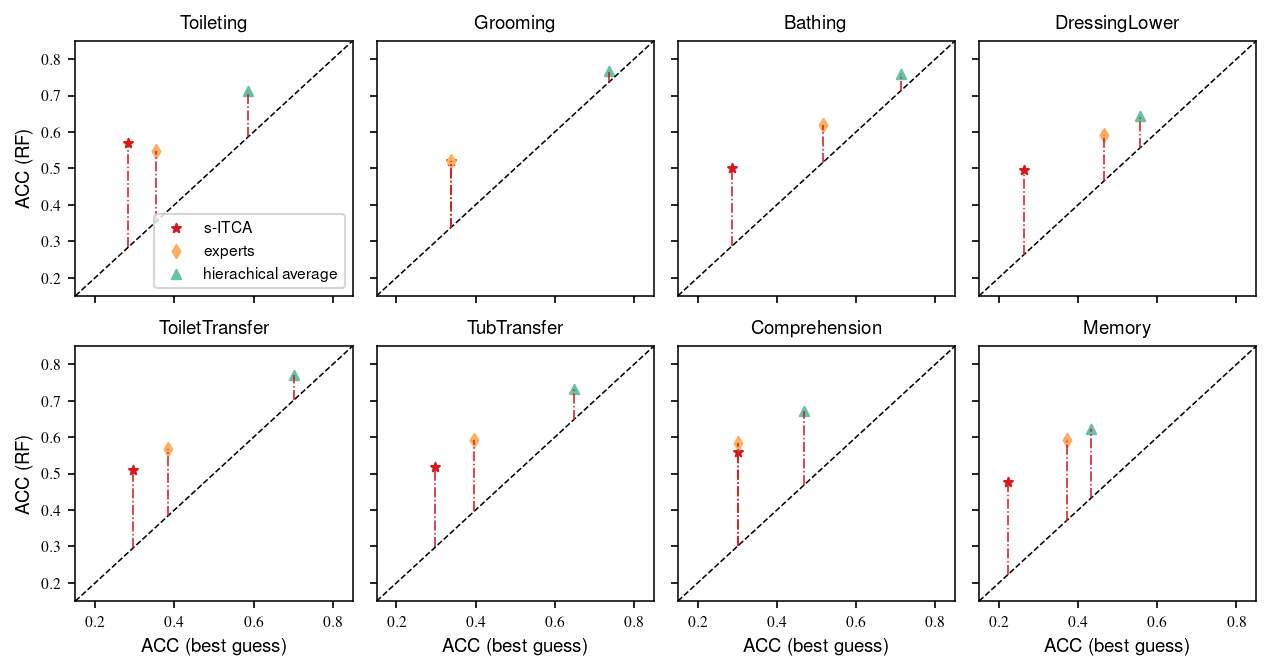

In [23]:
# ================ plot figure ================================== 
#The text is anotated by powerpoint.
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True)
ind_expert = 24
marker_size = 20
xl, yl = .15, .15
xu, yu = .85, .85
hide_text = (0, 1, 6)
names = ["itca", "expert", "average"] #["itca", "expert", "single", "complete", "average"]
#["optimal", "experts", "hierachical single", "hierachical complete", "hierachical average"]
marker_labels = ["s-ITCA", "experts", "hierachical average"]
colors = ["#d7191c", "#fdae61", '#66c2a4'] # ,'#66c2a4','#66c2a4']
marker_types = ["*", "d", "^"]
for ind in range(nrows * ncols):
    ax = axes[ind // ncols, ind % ncols]
    ax.set_xlim([xl, xu])
    ax.set_ylim([yl, yu])
    if ind >= 10:
        ax.axis("off")
        continue
    ax.plot([xl, xu], [yl, yu], 'k--')
    for inner_ind in range(len(names)):
        ax.scatter(guess_v[names[inner_ind]][ind], acc_v[names[inner_ind]][ind], 
                marker= marker_types[inner_ind], s=marker_size,  c=colors[inner_ind], 
                   label=marker_labels[inner_ind])
        ax.plot([guess_v[names[inner_ind]][ind], guess_v[names[inner_ind]][ind]], 
               [guess_v[names[inner_ind]][ind], acc_v[names[inner_ind]][ind]], 
                linestyle="-.", color="#d7191c")
#         ax.errorbar(guess_v[names[inner_ind]][ind], acc_v[names[inner_ind]][ind], 
#                     yerr=acc_std[names[inner_ind]][ind], barsabove=True, capsize=2, ecolor=colors[inner_ind])
        if names[inner_ind] in ("itca", "expert", "average") and ind in hide_text:
            pass
#         else:
#             ax.text(guess_v[names[inner_ind]][ind] - 0.04, 
#                 (guess_v[names[inner_ind]][ind] + acc_v[names[inner_ind]][ind])/2, 
#                 "{:.3f}".format( acc_v[names[inner_ind]][ind] - guess_v[names[inner_ind]][ind]),
#                bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
            
    ax.set_title(response_names[ind_list[ind]][8:])
    if ind == 0:
        ax.legend(loc="lower right")
    if ind >= 4:
        ax.set_xlabel("ACC (best guess)")
    if ind == 0 or ind == 4:
        ax.set_ylabel("ACC (RF)")
fig.set_size_inches(8.5, 4.5)
plt.tight_layout() 